In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from src.transformers.load_data_unique import LoadDataUnique
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from src.analog_discovery.analog_discovery import AnalogDiscovery
from src.analog_discovery.mces import MCES

## params

In [4]:
ls /Users/sebas/projects/data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_100_millions_more_epochs.ckpt
best_model_100_millions_more_epochs_day3.ckpt
best_model_1024n_10layers.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_150_millions.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
best_model_20240409_10_million_not_bining_sim_1.ckpt
best_model_20240409_1_million_not_bining_sim_1.ckpt
best_model_20240411_no_identity.ckpt
best_model_20240411_no_sim1.ckpt
best_model_20240507_100_millions_no_identity.ckpt
best_model_exhaustive_128n_20240522.ckpt
best_model_exhaustive_sampled_128n_20240523.ckpt
best_model_exhaustive_sampled_128n_20240523_with_pretrai

In [5]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
#model_path = data_folder + 'best_model_20240409_10_million_not_bining_sim_1.ckpt'
#model_path = data_folder + 'best_model_20240411_no_sim1.ckpt'
#model_path = data_folder + 'best_model_20240507_100_millions_no_identity.ckpt'
#model_path= data_folder + 'best_model_new_preprocessing_20240516.ckpt'
model_path= data_folder + 'best_model_100_millions_more_epochs_day3.ckpt'
#model_path = data_folder + 'best_model_150_millions.ckpt'
#model_path = data_folder + 'best_model_exhaustive_128n_20240522.ckpt'
#model_path = data_folder + 'best_model_exhaustive_sampled_128n_20240523_with_pretrained.ckpt'
#model_path = data_folder + 'best_model_20240411_no_identity.ckpt'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

In [6]:
config=Config()

In [21]:
config.D_MODEL=512
config.N_LAYERS=5


In [8]:
USE_CASMI=True

In [9]:
similarity_name= 'simba_casmi_more_epochs_day3'

## open janssen data

In [10]:
if USE_CASMI:
    all_spectrums_janssen=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

In [11]:
len(all_spectrums_janssen)

170

## open ref data

In [12]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [13]:
all_spectrums_reference= dataset['molecule_pairs_train'].spectrums_original +\
                    dataset['molecule_pairs_val'].spectrums_original + \
                        dataset['molecule_pairs_test'].spectrums_original


In [14]:
all_spectrums_reference[0].params

{'pepmass': (545.0, None),
 'charge': [0],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': '20111105_Jenia_Ger_Scytonemin_MH_545_qb.1.1..mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'GNPS-LIBRARY',
 'name': 'Scytonemin M+H',
 'pi': 'Gerwick',
 'datacollector': 'Amanda',
 'smiles': 'OC1=CC=C(\\C=C2\\C(=O)C(C3=C4C5=C(C=CC=C5)N=C4\\C(=C/C4=CC=C(O)C=C4)C3=O)=C3C4=C(C=CC=C4)N=C23)C=C1',
 'inchi': 'InChI=1S/C36H20N2O4/c39-21-13-9-19(10-14-21)17-25-33-29(23-5-1-3-7-27(23)37-33)31(35(25)41)32-30-24-6-2-4-8-28(24)38-34(30)26(36(32)42)18-20-11-15-22(40)16-12-20/h1-18,39-40H/b25-17+,26-18+',
 'inchiaux': 'CGZKSPLDUIRCIO-RPCRKUJJSA-N',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '1',
 'spectrumid': 'CCMSLIB00000001550',
 'scans': '1'}

In [15]:
all_spectrums_gnps = [s for s in all_spectrums_reference if s.params['spectrumid'].startswith('CCMS')]

In [16]:
all_spectrums_nist=[s for s in all_spectrums_reference if not(s.params['spectrumid'].startswith('CCMS'))]

## Find those instances that are not in reference

In [17]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [18]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(28, 142)

In [19]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load encoder

In [22]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

Using cosine library from Pytorch?: True


## data loader

In [23]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)


Preprocessing all the data ...


142it [00:02, 63.28it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [24]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


326386it [00:06, 48050.79it/s]


Finished preprocessing 
loading data
Normalizing intensities


In [25]:
#dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
#dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

In [26]:
#dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
#dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

tensor([[0.2655, 0.1981, 0.0976,  ..., 0.0000, 0.0000, 0.0000],
        [0.1026, 0.0798, 0.1023,  ..., 0.0000, 0.0000, 0.0000],
        [0.5295, 0.5637, 0.6339,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.3224, 0.0655, 0.1683,  ..., 0.0000, 0.0000, 0.0000],
        [0.0630, 0.0505, 0.0735,  ..., 0.0000, 0.0000, 0.0000],
        [0.0586, 0.0660, 0.0654,  ..., 0.0000, 0.0000, 0.0000]])


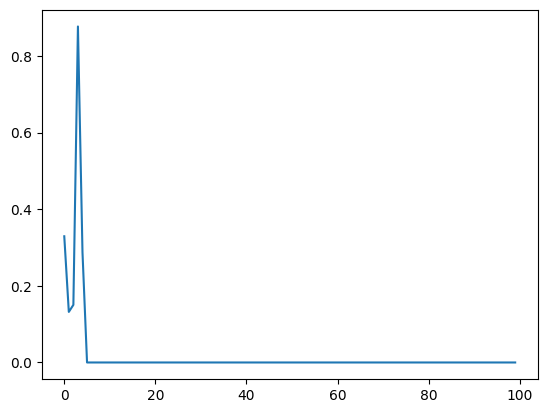

In [27]:
for batch in dataloader_reference:
    print(batch['intensity'])
    plt.plot(batch['intensity'][11])
    break

## forward

In [28]:
embeddings_janssen= encoder.get_embeddings(dataloader_janssen)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


In [29]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |                                                                                                 …

In [30]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [31]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities

In [32]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_janssen, embeddings_reference)

In [33]:
similarities.shape

(142, 326386)

## heat map

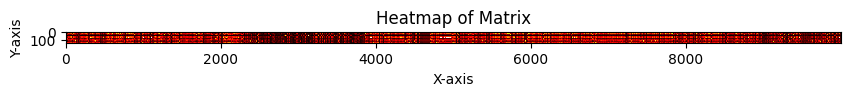

In [34]:
plt.figure(figsize=(10,100))
plt.imshow(similarities[:, 0:10000], cmap='hot', interpolation='nearest')
#plt.colorbar()  # Add colorbar to show scale
plt.title('Heatmap of Matrix')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

## Show PCA

In [35]:
from src.analog_discovery.pca_embeddings import PCAEmbeddings

In [36]:
pca = PCAEmbeddings()

In [37]:
pca.fit(embeddings_reference)

In [38]:
pca_ref= pca.transform(embeddings_reference)

In [39]:
pca_janssen= pca.transform(embeddings_janssen)

In [40]:
#pca_nist= pca.transform(embeddings_nist)

In [41]:
#pca_gnps= pca.transform(embeddings_gnps)

In [42]:
from src.plotting import Plotting

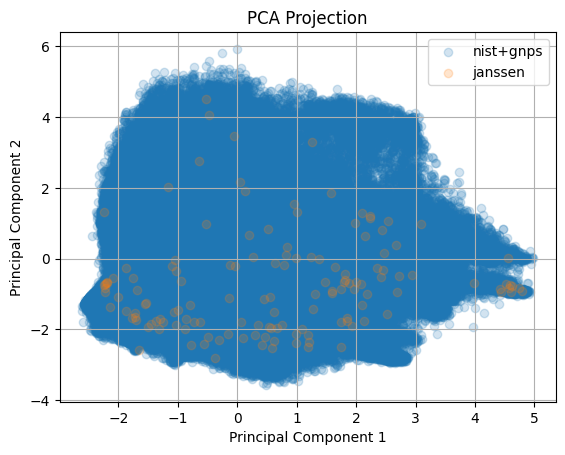

In [43]:
Plotting.plot_n_pca([pca_ref, pca_janssen,], ['nist+gnps','janssen', ], alpha=0.2)

## Based on the similarities compute the similarity score of the match spectrum

In [44]:
spectrums_retrieved, tanimoto_retrieved, max_sim = AnalogDiscovery.get_analog_spectrums_su(similarities, all_spectrums_reference, all_spectrums_janssen)

In [45]:
smiles_retrieved= [s.smiles for s in spectrums_retrieved]

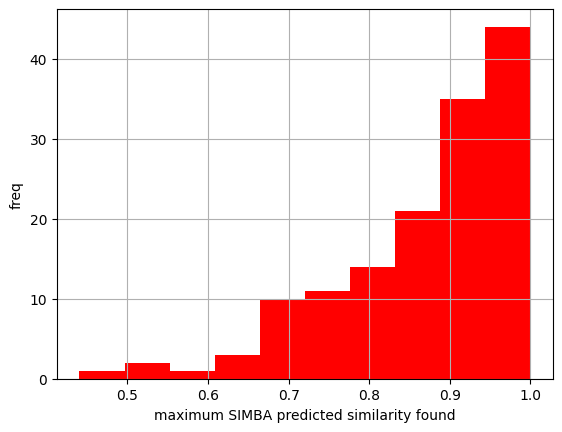

In [46]:
_=plt.hist(max_sim, color='r', bins=10)
plt.xlabel('maximum SIMBA predicted similarity found')
plt.ylabel('freq')
plt.grid()

Text(0, 0.5, 'frequency')

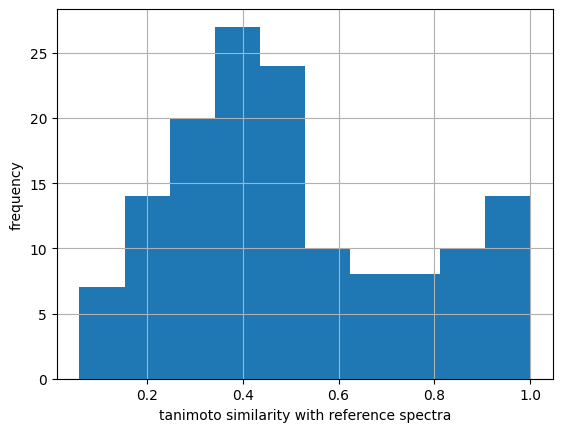

In [47]:
plt.hist(tanimoto_retrieved)
plt.grid()
plt.xlabel('tanimoto similarity with reference spectra')
plt.ylabel('frequency')

Text(0.5, 0, 'tanimoto')

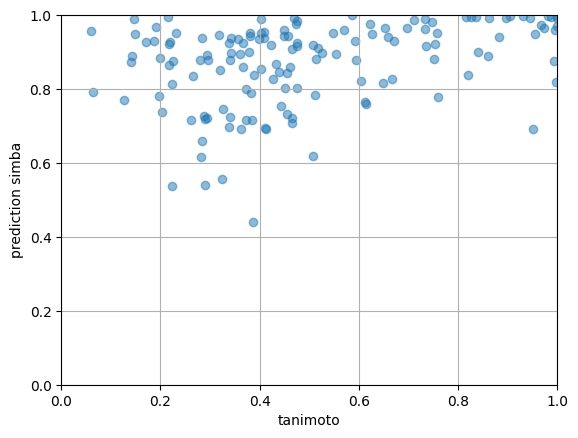

In [48]:
plt.scatter(tanimoto_retrieved, max_sim, alpha=0.5)
plt.xlim([0,1])
plt.ylim([0,1])
plt.grid()
plt.ylabel('prediction simba')
plt.xlabel('tanimoto')

## Check which is the spectra that has wrong predictions

In [49]:
target_index=-5

In [50]:
bad_predictions=np.argsort(abs(tanimoto_retrieved-max_sim))[::-1]

In [51]:
target_spectra=bad_predictions[target_index]

In [52]:
all_spectrums_janssen[target_spectra].params

{'spectrumid': '332 M+H',
 'name': '332 M+H',
 'inchi': '',
 'organism': 'casmi',
 'id': 332,
 'smiles': 'CC1OC(OC2C(Oc3c(-c4ccc(O)cc4)oc4cc(OC5OC(COC(=O)C=Cc6ccc(O)cc6)C(O)C(O)C5O)cc(O)c4c3=O)OC(CO)C(O)C2O)C(O)C(O)C1O',
 'ionmode': 'Positive',
 'pepmass': [903.254591557378],
 'charge': [1],
 'libraryquality': 1}

In [53]:
spectrums_retrieved[target_spectra].params

{'libraryquality': 1,
 'charge': [1],
 'pepmass': [903.2553],
 'ionmode': 'Positive',
 'name': ' 5-Hydroxy-2-(4-hydroxyphenyl)-7-((2-O-((2E)-3-(4-hydroxyphenyl)prop-2-enoyl)-.beta.-D-glucopyranosyl)oxy)-4-oxo-4H-chromen-3-yl 2-O-(6-deoxy-.alpha.-L-mannopyranosyl)-.beta.-D-glucopyranoside\n M+H',
 'inchi': 'N/A',
 'smiles': 'CC1C(C(C(C(O1)OC2C(C(C(OC2OC3=C(OC4=CC(=CC(=C4C3=O)O)OC5C(C(C(C(O5)CO)O)O)OC(=O)C=CC6=CC=C(C=C6)O)C7=CC=C(C=C7)O)CO)O)O)O)O)O',
 'organism': 'nist',
 'spectrumid': 'abcd'}

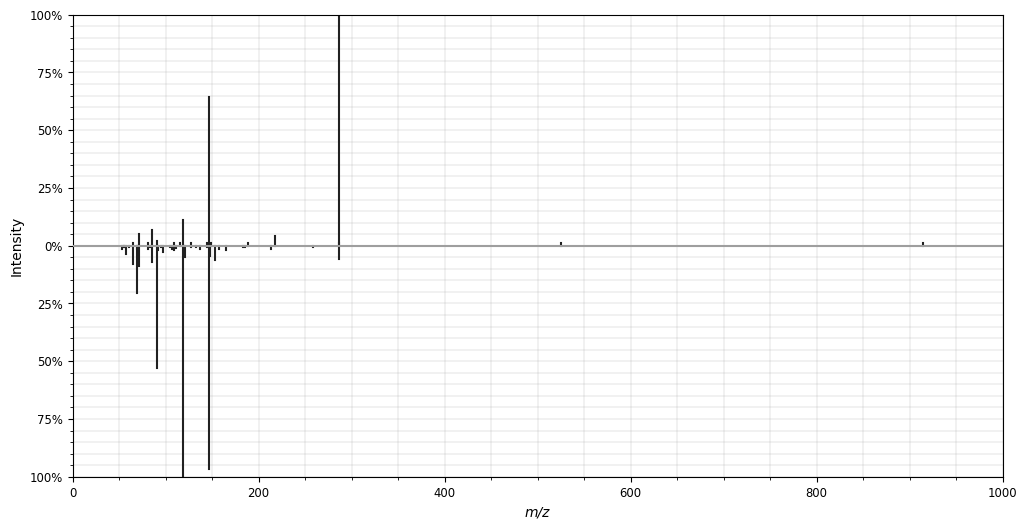

In [54]:
Plotting.plot_mirror_plot( all_spectrums_janssen[target_spectra],spectrums_retrieved[target_spectra])

In [55]:
## pass through preprocessing:
pp=Preprocessor()
import copy

spectrum_copy= copy.deepcopy(spectrums_retrieved[target_spectra])
spectrum_copy=pp.preprocess_spectrum(spectrum_copy)

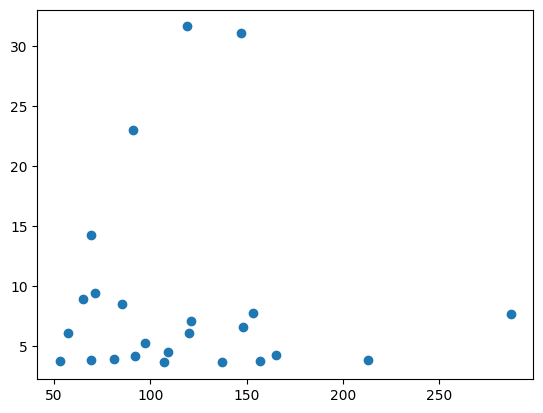

In [56]:
plt.scatter(spectrum_copy.mz, spectrum_copy.intensity)

In [57]:
len(spectrums_retrieved[target_spectra].intensity)

45

In [58]:
len(max_sim)

142

In [59]:
max_sim[target_spectra]

0.9962574

In [60]:
tanimoto_retrieved[target_spectra]

0.9866760168302945

In [61]:
sim_mces = MCES.calculate_mces_sim(smiles1=all_spectrums_janssen[target_spectra].params['smiles'], 
                         smiles2=spectrums_retrieved[target_spectra].params['smiles'])
sim_mces

Too many matching bond pairs (1348) so can't continue.


1.0

In [62]:
Chem.CanonSmiles(all_spectrums_janssen[target_spectra].params['smiles'])

'CC1OC(OC2C(Oc3c(-c4ccc(O)cc4)oc4cc(OC5OC(COC(=O)C=Cc6ccc(O)cc6)C(O)C(O)C5O)cc(O)c4c3=O)OC(CO)C(O)C2O)C(O)C(O)C1O'

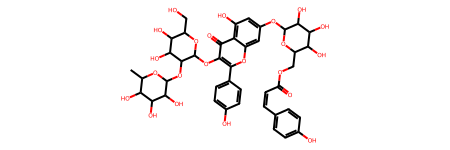

In [63]:
from rdkit import Chem
mol_janssen = Chem.MolFromSmiles(all_spectrums_janssen[target_spectra].params['smiles'])
mol_janssen

In [64]:
Chem.CanonSmiles(spectrums_retrieved[target_spectra].params['smiles'])

'CC1OC(OC2C(Oc3c(-c4ccc(O)cc4)oc4cc(OC5OC(CO)C(O)C(O)C5OC(=O)C=Cc5ccc(O)cc5)cc(O)c4c3=O)OC(CO)C(O)C2O)C(O)C(O)C1O'

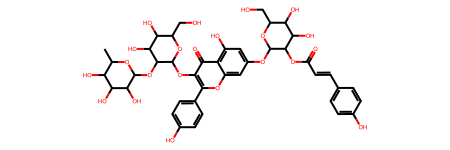

In [65]:
mol_ref = Chem.MolFromSmiles(spectrums_retrieved[target_spectra].params['smiles'])
mol_ref

## FIND SIMILARITY BASED ON MCES

In [66]:
smiles_janssen = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]

In [67]:
len(smiles_retrieved)

142

In [68]:
len(smiles_janssen)

142

In [69]:
mces_sims=[]
for s0,s1 in tqdm(zip(smiles_janssen, smiles_retrieved)):
    similarity= MCES.calculate_mces_sim(s0, s1)
    mces_sims.append(similarity)

0it [00:00, ?it/s]Too many matching bond pairs (1104) so can't continue.
55it [00:05,  8.83it/s] Too many matching bond pairs (1045) so can't continue.
Too many matching bond pairs (1076) so can't continue.
93it [00:05, 18.60it/s]Too many matching bond pairs (1348) so can't continue.
Too many matching bond pairs (1034) so can't continue.
Too many matching bond pairs (1054) so can't continue.
Too many matching bond pairs (1153) so can't continue.
Too many matching bond pairs (1660) so can't continue.
142it [00:05, 24.95it/s]


In [70]:
# Specify the bin width
bin_width = 0.1

# Calculate the number of bins based on the data range and bin width
bins = np.arange(0, 1 + bin_width, bin_width)

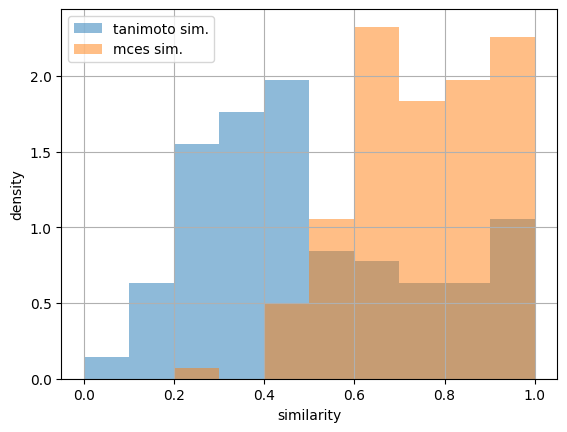

In [71]:
plt.hist(tanimoto_retrieved,alpha=0.5, label='tanimoto sim.', density=True, bins=bins)
plt.hist([m for m in mces_sims if m is not None],alpha=0.5, label='mces sim.', density=True, bins=bins)
plt.xlabel('similarity')
plt.ylabel('density')
plt.legend()
plt.grid()

## Rankings

In [74]:
format_file_unknown = "./notebooks/discovery_search/results/{}_results_analog_discovery_unknwon_compounds.pkl"

if USE_CASMI:
    file= format_file_unknown.format('tanimoto_similarity_casmi')
else:
    file= format_file_unknown.format('tanimoto_similarity')
with open(file, 'rb') as f:
        results_tani = dill.load(f)

In [75]:
## load the tanimoto similarity data
## get the indexes in the reference data
smiles_best_candidate_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_retrieved']]
smiles_reference_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_reference']]
smiles_janssen_loaded = [Chem.CanonSmiles(s) for s in results_tani['smiles_janssen']]

In [76]:
#list_rankings=[]

In [77]:
list_rankings=AnalogDiscovery.get_rank_of_best_candidate(similarities, smiles_janssen, smiles_janssen_loaded, smiles_reference, smiles_best_candidate_loaded)

## saving of results

In [78]:
len(max_sim), len(tanimoto_retrieved), len(all_spectrums_janssen), len(smiles_retrieved), len(mces_sims), len(smiles_janssen), len(spectrums_retrieved)

(142, 142, 142, 142, 142, 142, 142)

In [79]:
results ={ 'preprocessed_all_spectrums_janssen':all_spectrums_janssen,
            'smiles_janssen':smiles_janssen,
          'smiles_retrieved':smiles_retrieved,
          'spectrums_retrieved':spectrums_retrieved,
            'tanimoto_retrieved':tanimoto_retrieved,
          'max_sim':max_sim,
          'mces_retrieved':mces_sims,
          'smiles_reference': smiles_reference,
          'list_rankings':list_rankings}

In [80]:
with open('./notebooks/discovery_search/results/'+similarity_name + '_results_analog_discovery_unknwon_compounds.pkl', 'wb') as f:
    dill.dump(results, f)

In [ ]:
import numpy as np
a=np.zeros(3, dtype=np.float16)

In [ ]:
a[1]=0.5332324254353465464564654645654654645654565

In [ ]:
a

In [ ]:
np.save(arr=a, file='test_file.npy')

In [ ]:
ls